In [4]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import torchvision.transforms as transforms
import numpy as np
import os
from PIL import Image
from IPython import display
import matplotlib.pyplot as plt
import glob
%matplotlib inline
device = "cuda"

In [5]:
preprocess = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
class CycleGANDataset(torch.utils.data.Dataset):
    def __init__(self, folder):
        self.files_a = glob.glob(os.path.join(folder+'A/*.jpg'))
        self.files_b = glob.glob(os.path.join(folder+'B/*.jpg'))
        self.images = []
        for fn_a, fn_b in zip(self.files_a, self.files_b):
            if len(self.images) % 100 == 0:
                print(len(self.images))
            try:
                image_a = preprocess(Image.open(fn_a))
                image_b = preprocess(Image.open(fn_b))
            except IOError:
                continue
            self.images.append((image_a, image_b))
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        out_data = self.images[idx]
        return out_data
dataset = CycleGANDataset("/home/yanai-lab/terauchi-k/export/jupyter/notebook/pytorch-CycleGAN-and-pix2pix/datasets/datasets/apple2orange/train")


0
100
200
300
400
500
600
700
800
900


In [8]:
class DownSamp(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DownSamp, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=2,padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1,padding=1)
        self.conv3 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1,padding=1)
    def forward(self, x):
        x = self.conv1(x)
        x = F.leaky_relu(x)
        x = self.conv2(x)
        x = F.leaky_relu(x)
        x = self.conv3(x)
        x = F.leaky_relu(x)
        return x
class UpSamp(nn.Module):
    def __init__(self, in_ch, cat_ch, out_ch):
        super(UpSamp, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_ch,in_ch//2,kernel_size=4, stride=2,padding=1)
        #forwardでcatする catするサイズはアップサンプル後
        self.conv1 = nn.Conv2d(in_ch//2+cat_ch, out_ch, kernel_size=3, stride=1,padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1,padding=1)
    def forward(self,x, cat):
        x = self.deconv(x)
        x = F.leaky_relu(x)
        x = torch.cat((x, cat),axis=1)
        x = self.conv1(x)
        x = F.leaky_relu(x)
        x = self.conv2(x)
        x = F.leaky_relu(x)
        return x
d = DownSamp(32,64)
u = UpSamp(64,32,32)
d(torch.zeros((1,32,64,64)))
u(torch.zeros((1,64,32,32)),torch.zeros((1,32,64,64))).shape
class UNet(nn.Module):
    def __init__(self):
        super(UNet,self).__init__()
        self.in1 = nn.Conv2d(3, 32, kernel_size=7,stride=1,padding=3)
        self.in2 = nn.Conv2d(32, 32, kernel_size=3,stride=1,padding=1)
        self.down1 = DownSamp(32,64)
        self.down2 = DownSamp(64,128)
        self.down3 = DownSamp(128,256)
        self.down4 = DownSamp(256,512)
        self.up4 = UpSamp(512,256,256)
        self.up3 = UpSamp(256,128,128)
        self.up2 = UpSamp(128,64,64)
        self.up1 = UpSamp(64,32,32)
        self.out = nn.Conv2d(32,3, kernel_size=7, stride=1, padding=3)
    def forward(self,x):
        x = self.in1(x)
        x = F.leaky_relu(x)
        x1 = self.in2(x)
        x1 = F.leaky_relu(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up4(x5,x4)
        x = self.up3(x, x3)
        x = self.up2(x, x2)
        x = self.up1(x, x1)
        x = self.out(x)
        x = torch.sigmoid(x)
        return x


In [14]:
from torch.nn.utils.spectral_norm import spectral_norm

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()        
        self.main = nn.Sequential(
            nn.Conv2d(3, 32, stride=2, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(32, 64, stride=2, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(64, 128, stride=2, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(128, 256, stride=2, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256,256,stride=2,kernel_size=3,padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256,512,stride=2,kernel_size=3,padding=1),
            nn.LeakyReLU(0.1),
            #nn.Conv2d(1024,1024,stride=1,kernel_size=1,padding=0),
            nn.Conv2d(512,1,stride=1,kernel_size=1,padding=0),
            nn.Flatten(),
        )
    def forward(self, x):
        return (self.main(x).squeeze_(1))
d = Discriminator()
d(torch.zeros((1,3,256,256))).shape

torch.Size([1, 16])

tensor(2.0833, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.1382, device='cuda:0', grad_fn=<AddBackward0>)
a->b


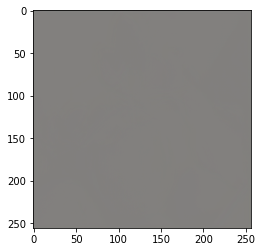

b->a


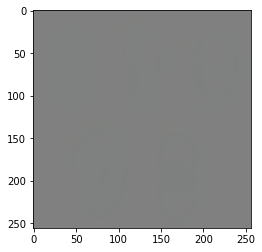

tensor(0.3842, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.3233, device='cuda:0', grad_fn=<AddBackward0>)
a->b


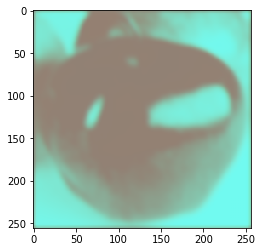

b->a


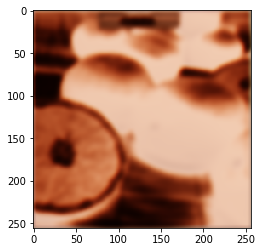

tensor(0.7328, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.4905, device='cuda:0', grad_fn=<AddBackward0>)
a->b


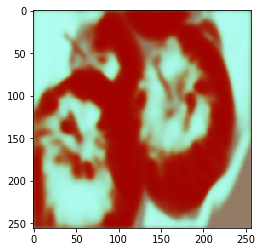

b->a


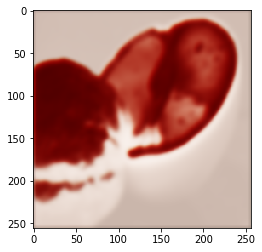

tensor(0.8969, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9420, device='cuda:0', grad_fn=<AddBackward0>)
a->b


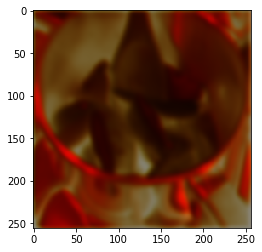

b->a


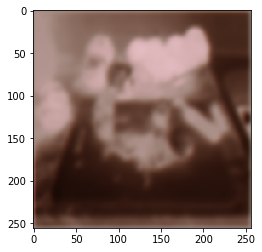

tensor(0.7798, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.2110, device='cuda:0', grad_fn=<AddBackward0>)
a->b


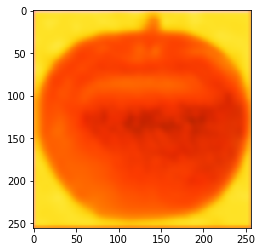

b->a


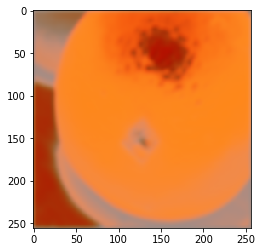

tensor(0.6324, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1971, device='cuda:0', grad_fn=<AddBackward0>)
a->b


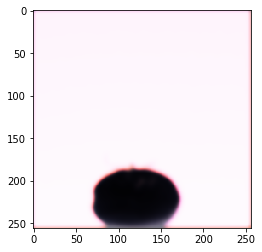

b->a


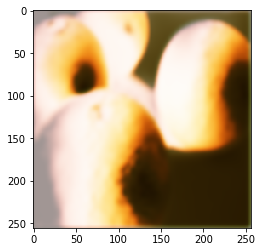

tensor(0.5658, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0343, device='cuda:0', grad_fn=<AddBackward0>)
a->b


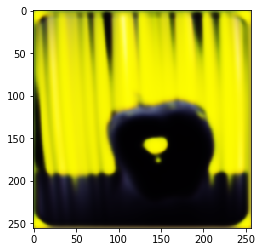

b->a


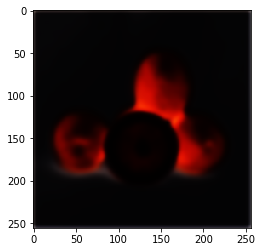

In [ ]:
batch_size=1
epoch = 10
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True)
g_ab = UNet().to(device)
g_ba = UNet().to(device)
d_a = Discriminator().to(device)
d_b = Discriminator().to(device)
#zero_ = torch.zeros((batch_size,64)).to(device)
#one_ = torch.ones((batch_size,64)).to(device)
lossfunc = nn.MSELoss()
opt_g_ab = opt.SGD(params=g_ab.parameters(),lr=1e-3, momentum=0.8)
opt_g_ba = opt.SGD(params=g_ba.parameters(),lr=1e-3, momentum=0.8)
opt_d_a = opt.SGD(params=d_a.parameters(),lr=1e-2, momentum=0.8)
opt_d_b = opt.SGD(params=d_b.parameters(),lr=1e-2, momentum=0.8)
#g_opt = opt.Adam(params=g.parameters())
#d_opt = opt.Adam(params=d.parameters())
itr = 0
for ep in range(epoch):
    for (img_a, img_b) in dataloader:
        itr+=1
        img_a = img_a.to(device)
        img_b = img_b.to(device)
        fake_b = g_ab(img_a)
        fake_a = g_ba(img_b)
        rec_a = g_ba(fake_b)
        rec_b = g_ab(fake_a)
        
        zero_ = torch.zeros((img_a.shape[0],16)).to(device)
        one_ = torch.ones((img_a.shape[0],16)).to(device)
        
        l_g_aba_rec = torch.mean(torch.abs(img_a-rec_a))
        l_g_bab_rec = torch.mean(torch.abs(img_b-rec_b))
        l_g_ab_adv = lossfunc(d_a(fake_a),one_)
        l_g_ba_adv = lossfunc(d_b(fake_b),one_)
        
        l_g = (l_g_ab_adv + l_g_ba_adv) + (l_g_aba_rec+l_g_bab_rec)*0.1
        
        g_ab.zero_grad()
        g_ba.zero_grad()
        l_g.backward()
        opt_g_ab.step()
        opt_g_ba.step()
        
        
        l_d_a_adv = lossfunc(d_a(fake_a.detach()),zero_)+lossfunc(d_a(img_a),one_)
        l_d_b_adv = lossfunc(d_b(fake_b.detach()),zero_)+lossfunc(d_b(img_b),one_)
        
        l_d = l_d_a_adv + l_d_b_adv
        
        d_a.zero_grad()
        d_b.zero_grad()
        l_d.backward()
        opt_d_a.step()
        opt_d_b.step()
                

        if itr % 1000 == 1:
            print(l_d, l_g)
            print("a->b")
            plt.imshow(fake_b.detach()[0].cpu().numpy().transpose(1,2,0))
            plt.show()
            print("b->a")
            plt.imshow(fake_a.detach()[0].cpu().numpy().transpose(1,2,0))
            plt.show()